# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import decomposition
from scipy.interpolate import interp2d
from scipy.signal import find_peaks, peak_prominences, peak_widths

from src.models import nmf_missing
from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Read metadata

In [5]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Dcum2,QPS Crate,QPS Board,#Segment,phys_pos,Name,R_1,R_2,RRR_1,RRR_2
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,268.9040,B8R1,0,79,1,A8R1,1.80,1.85,95.650088,94.103943
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,284.5640,B9R1,0,77,2,B8R1,1.67,1.85,100.314516,94.103943
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,307.9690,B8R1,1,80,3,A9R1,1.75,1.85,97.936878,94.103943
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,323.6290,B11R1,2,76,4,B9R1,1.67,1.77,100.314516,97.371760
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,348.4340,B10R1,0,81,5,A10R1,1.67,1.67,100.314516,100.314516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,26294.7892,B10L1,1,75,150,A10L1,2.53,3.13,78.314002,70.353447
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,26319.5942,B9L1,1,80,151,B9L1,3.25,3.70,68.099268,54.735949
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,26335.2542,B10L1,2,76,152,A9L1,3.09,1.75,70.748254,99.628927
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,26358.6592,B9L1,0,79,153,B8L1,2.43,2.43,79.915648,79.899869


In [6]:
rb_magnet_metadata['cryostat_group'] = rb_magnet_metadata['Cryostat2'].apply(lambda x: x.split('_')[1])
last_mpos_in_cryostat = rb_magnet_metadata[rb_magnet_metadata.Circuit=='RB.A12'].groupby("cryostat_group").min().sort_values(by='phys_pos').phys_pos.values

# FFT Analysis

In [7]:
from scipy import signal
from scipy.fft import fft, fftfreq, rfft
from matplotlib import colors

def complex_to_polar(x):
    amplitude = np.abs(x)
    phase = np.arctan2(np.imag(x), np.real(x))  # *180/np.pi
    return amplitude, phase

def get_fft_amplitude(x):
    N = len(x)
    
    if np.isnan(x).all():
        y_FFT = fft(np.nan_to_num(x))
        y_FFT = np.zeros_like(y_FFT) * np.nan
    else:
        x = x[~np.isnan(x)]
        x = x * np.hanning(len(x))
        #x = pd.DataFrame(x).rolling(3).median().values.reshape(-1) #salt and peper noise
        y_FFT = fft(np.nan_to_num(x))
    return 2.0 / N * np.abs(y_FFT[0:N // 2])

def get_fft_amplitude_nohanning(x):
    N = len(x)
    
    if np.isnan(x).all():
        y_FFT = fft(np.nan_to_num(x))
        y_FFT = np.zeros_like(y_FFT) * np.nan
    else:
        x = x[~np.isnan(x)]
        #x = pd.DataFrame(x).rolling(3).median().values.reshape(-1) #salt and peper noise
        y_FFT = fft(np.nan_to_num(x))
    return 2.0 / N * np.abs(y_FFT[0:N // 2])

def get_fft_phase(DC_Down_data):
    N = len(DC_Down_data)
    x = fft(DC_Down_data)
    return np.arctan2(np.imag(x), np.real(x))[0:N // 2]


def plot_circuit_frequencies_phys_pos(ax, x_fft, frequency, rb_magnet_metadata_subset):
        
    #phys_pos = rb_magnet_metadata_subset.sort_values(by='#Electric_circuit').phys_pos.values #np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))
    #phys_pos_sorted = np.argsort(phys_pos)+1
    phys_pos_index = rb_magnet_metadata_subset['#Electric_circuit'].values 
    
    im = ax.imshow(x_fft[phys_pos_index-1].T, extent=[1,154, frequency.min(),frequency.max()], vmin=1e-5, vmax=1e-2, aspect='auto', norm=colors.LogNorm(), origin='lower')
    ax.set_ylabel('Frequency / Hz')
    ax.set_xlabel('Phy. Position')
    ax.set_xticks(np.arange(1,155)[::9])
    
    last_mpos_in_cryostat = rb_magnet_metadata_subset.groupby("cryostat_group").min().sort_values(by='phys_pos').phys_pos.values
    ax.set_xticks(last_mpos_in_cryostat)
    tick_labels = [str(l) if i%3==0 else  '' for i, l in enumerate(last_mpos_in_cryostat)] 
    ax.set_xticklabels(tick_labels)
    
    #plt.title('Frequency Domain')

    #cbar = fig.colorbar(im, ax=ax)
    #cbar.set_label('Voltage')

    plt.tight_layout()
    return im

def plot_circuit_frequencies(ax, x_fft, frequency, rb_magnet_metadata_subset):
    im = ax.imshow(x_fft.T, extent=[1,154, frequency.min(),frequency.max()], vmin=1e-5, vmax=1e-2, aspect='auto', norm=colors.LogNorm(), origin='lower')
    
    ax.set_ylabel('Frequency / Hz')
    ax.set_xlabel('El. Position')
    ax.set_xticks(np.arange(1,155)[::9])

    plt.tight_layout()
    return im


In [8]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/FFT_analysis/1EE_plateau_test")
#dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")
#plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/FFT_analysis/2EE_plateau")
plot_dataset_path.mkdir(parents=True, exist_ok=True)

context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")
metadata_path = Path("../data/RB_metadata.csv")

In [9]:
ds = RBFPAPrimQuenchEEPlateau2(dataset_path=dataset_path,
             context_path=context_path,
             metadata_path=metadata_path,
             data_path=data_path,
             simulation_path=simulation_path,
             acquisition_summary_path=acquisition_summary_path,
             plot_dataset_path=plot_dataset_path)

fpa_identifiers = ds.select_events()

dataset = ds.load_dataset(fpa_identifiers=fpa_identifiers, 
                          dataset_path=dataset_path, 
                          drop_data_vars=['el_position_feature','event_feature'])

dataset_scaled = dataset.copy(deep=True)
dataset_scaled = ds.train_valid_test_split(dataset=dataset_scaled)
dataset_scaled = ds.scale_dataset(dataset=dataset_scaled)

# Signal vs. scaled signal

In [10]:
fpa_identifier = fpa_identifiers[50]
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]

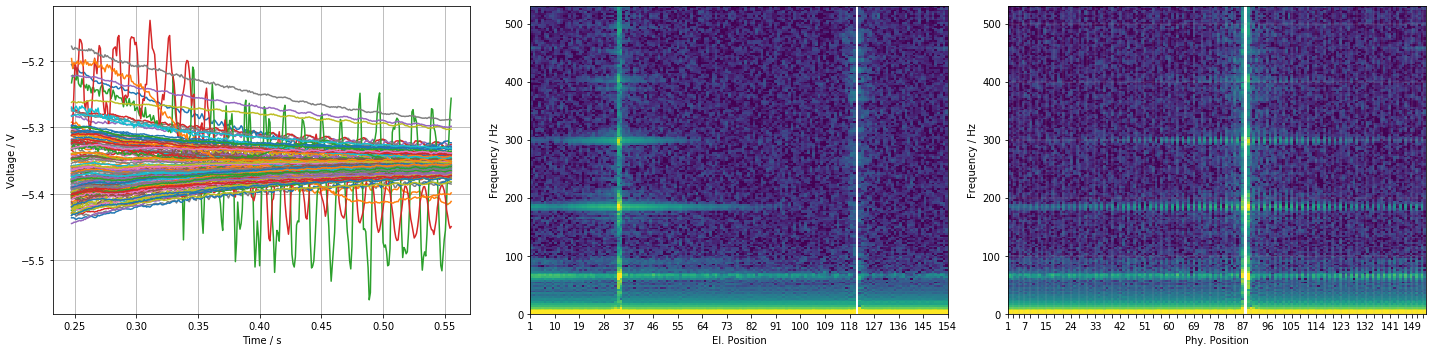

In [11]:
rb_magnet_metadata_subset = rb_magnet_metadata[rb_magnet_metadata.Circuit==str(fpa_identifier).split('_')[1]]

x_time = dataset.loc[{'event': fpa_identifier}].data
x_fft = np.array([get_fft_amplitude(x) for x in x_time])
dt= dataset[{'event': 0}].time[1].values -dataset[{'event': 0}].time[0].values
frequency = fftfreq(len(x_time[0]), dt)[:len(x_time[0])//2] 

fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.plot(x_time.T)
ax[0].set_xlabel('Time / s')
ax[0].set_ylabel('Voltage / V')
ax[0].plot(dataset.loc[{'event': fpa_identifier}].time, dataset.loc[{'event': fpa_identifier}].data.T)
ax[0].grid()

plot_circuit_frequencies(ax[1], x_fft, frequency, rb_magnet_metadata_subset)

plot_circuit_frequencies_phys_pos(ax[2], x_fft, frequency, rb_magnet_metadata_subset)
ax[2].grid(linewidth=0.2)

# Calculate fft of all events

In [12]:
dataset_fft = xr.apply_ufunc(get_fft_amplitude, 
                             dataset.data,
                             input_core_dims=[['time']], 
                             output_core_dims=[['frequency']], 
                             exclude_dims=set(("time",)),
                             vectorize=True)

# Center signals

In [13]:
def extend_to_centered_matrix(matrix, center):
    mask = np.zeros((len(matrix)*2, len(matrix[0]))) * np.nan
    start = len(matrix) - center
    end = start + len(matrix)
    mask[int(start): int(end)] = matrix
    return mask


def preprocess_event(x_fft, frequency, fpa_identifier, max_freq=360):
    max_freq_bool = frequency <= max_freq
    
    x_fft_cut = x_fft[:,max_freq_bool]
    mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df['fpa_identifier'] == fpa_identifier)]
    prim_quench_position = mp3_fpa_df_subset['#Electric_circuit'].values[0]
    x_fft_centered = extend_to_centered_matrix(matrix=x_fft_cut, center=prim_quench_position)

    return x_fft_centered, frequency[max_freq_bool]

def preprocess_event_phys_pos(x_fft, frequency, fpa_identifier, max_freq=360):
    max_freq_bool = frequency <= max_freq
    
    x_fft_cut = x_fft[:,max_freq_bool]
    mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df['fpa_identifier'] == fpa_identifier)]
    prim_quench_position = mp3_fpa_df_subset['phys_position'].values[0]
    x_fft_centered = extend_to_centered_matrix(matrix=x_fft_cut, center=prim_quench_position)

    return x_fft_centered, frequency[max_freq_bool]

In [14]:
fpa_identifiers = mp3_fpa_df[(mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 > 1) & 
                             (mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)
                            ].fpa_identifier.unique()

fpa_identifiers = fpa_identifiers[np.isin(fpa_identifiers, dataset.event.values)]
len(fpa_identifiers)

542

# Center signals: mirror el position

In [15]:
def extend_to_centered_matrix_mirror(matrix, center):
    im_len = int(len(matrix)/2)
    if center > len(matrix) / 2:
        # quench is in second half
        matrix_main = matrix[im_len:]
        matrix_mirror  = matrix[:im_len]
        center_main = center - im_len
        center_mirror = len(matrix) - center
    else:
        # center is in first half
        matrix_main = matrix[:im_len]
        matrix_mirror  = matrix[im_len:]
        center_main = center 
        center_mirror = im_len - center

        
    matrix_main_centered = extend_to_centered_matrix(matrix_main, center_main)
    matrix_mirror_centered = extend_to_centered_matrix(matrix_mirror, center_mirror)
    return matrix_main_centered, matrix_mirror_centered#

def preprocess_event_mirror(x_fft, frequency, fpa_identifier, max_freq=360):
    max_freq_bool = frequency <= max_freq
    
    x_fft_cut = x_fft[:,max_freq_bool]
    mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df['fpa_identifier'] == fpa_identifier)]
    prim_quench_position = mp3_fpa_df_subset['#Electric_circuit'].values[0]
    #print(prim_quench_position)
    x_fft_list = extend_to_centered_matrix_mirror(matrix=x_fft_cut, center=prim_quench_position)

    return x_fft_list, frequency[max_freq_bool]

In [16]:
def plot_position_frequency_map(ax, x_fft, frequency, norm=colors.LogNorm(), vmin=1e-5, vmax=1e-2):
    im = ax.imshow(x_fft.T, extent=[-77,77, frequency.min(),frequency.max()], vmin=vmin, vmax=vmax, aspect='auto', norm=norm, origin='lower')
    
    ax.set_ylabel('Frequency / Hz')
    ax.set_xlabel('El. Distance to Quench')
    
    plt.tight_layout()
    return im

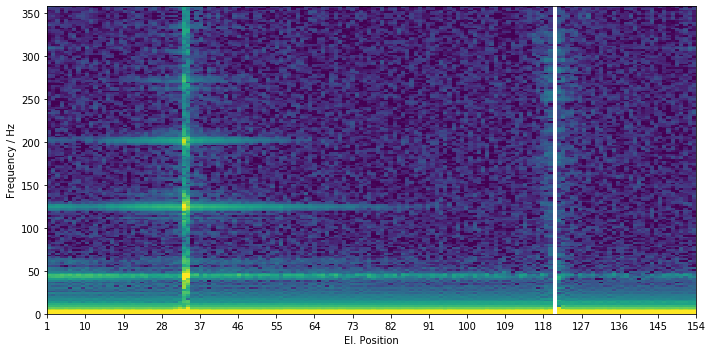

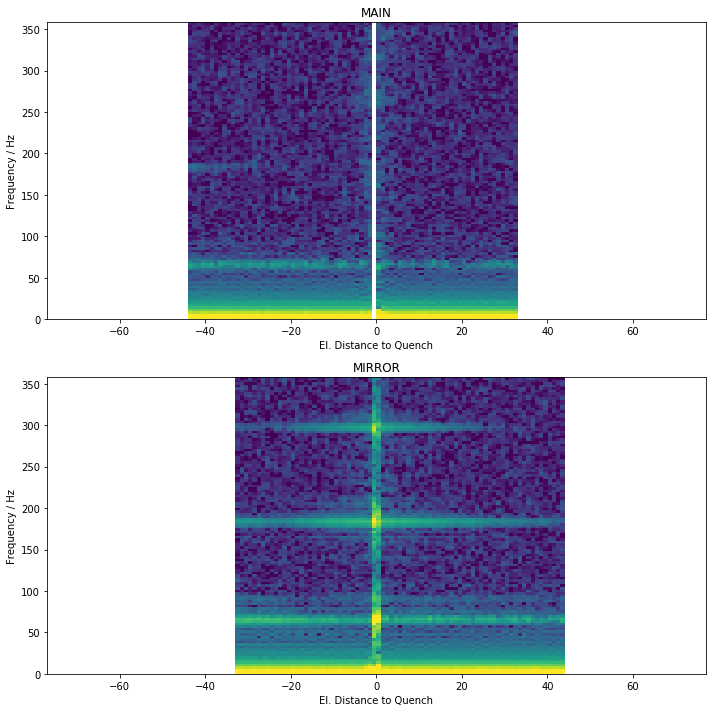

In [17]:
x_fft_list, frequency_cut = preprocess_event_mirror(x_fft, frequency, fpa_identifier, max_freq=360)

fig, ax = plt.subplots(figsize=(10,5))
plot_circuit_frequencies(ax, x_fft, frequency_cut, rb_magnet_metadata_subset)

fig, ax = plt.subplots(2,1, figsize=(10,10))
plot_position_frequency_map(ax[0], x_fft_list[0], frequency_cut)
ax[0].set_title('MAIN')
ax[1].set_title('MIRROR')
plot_position_frequency_map(ax[1], x_fft_list[1], frequency_cut)

# Scale Data

In [18]:
def log_scale_data(X, vmin=1e-5, vmax=1e-2):
    X_log = np.log10(X)
    vmin_log =np.log10(vmin)
    vmax_log =np.log10(vmax)
    X_std = (X_log - vmin_log) / (vmax_log - vmin_log)
    
    #clip
    X_std[X_std < 0] = 0
    X_std[X_std > 1] = 1
    return X_std

# Global Statics

In [ ]:
# el pos plot std
x_fft_all = np.zeros((2, len(fpa_identifiers), 154, 116)) #116

for i, fpa_identifier in enumerate(fpa_identifiers): 
    x_fft = dataset_fft.loc[{'event': fpa_identifier}].data
    x_fft_list, frequency_cut = preprocess_event_mirror(x_fft, frequency, fpa_identifier, max_freq=360)
    x_fft_all[0, i] = x_fft_list[0]
    x_fft_all[1, i] = x_fft_list[1]
    
x_fft_3q_main = np.nanquantile(x_fft_all[0], 0.75,  axis=0)
x_fft_3q_mirror = np.nanquantile(x_fft_all[1], 0.75, axis=0)

In [ ]:
v_properties_main, h_properties_main = get_peak_borders(x_fft_3q_main)
v_properties_mirror, h_properties_mirror = get_peak_borders(x_fft_3q_mirror)

fig, ax = plt.subplots(2,1, figsize=(10,10))
plot_position_frequency_map(ax[0], x_fft_3q_main, frequency_cut)
ax[0].set_title('MAIN')

plot_position_frequency_map(ax[1], x_fft_3q_mirror, frequency_cut)
ax[1].set_title('MIRROR')

plt.tight_layout()
plt.show()

# calc statisticvs

In [ ]:
def get_horizontal_peak_widths(x_fft, peaks, plot=False):
    peak_width_list = []
    df = pd.DataFrame()
    for x in x_fft.T[peaks]:
        nan_bool = np.isnan(x)
        nan_index = np.argmax(nan_bool)
        x[nan_bool] = np.interp(nan_index, np.arange(len(x[~nan_bool])), x[~nan_bool])
        
        peaks, properties = find_peaks(x, prominence=0.2, width=1, rel_height=0.9)
        properties['peaks'] = peaks
        
        if np.nanmean(x_fft) < (np.nanmean(x)- np.nanstd(x_fft)):
            properties['widths'] = len(x)
        
        df_new = pd.DataFrame(properties)
        df = pd.concat([df,df_new])
        
        if plot==True:
            plt.figure()
            plt.plot(np.arange(1,155)-77, x)
            plt.xlabel('El. Distance to Quench')
            plt.ylabel('Voltage Log-Scale')
            plt.plot(peaks-76, x[peaks], "X",  markersize=10)
            #plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"]-76, xmax=properties["right_ips"]-76, color = "C2")
            
            plt.hlines(y=np.mean(x), xmin=-76, xmax=76, color = "C2", label=f"mean=10^{np.mean(x):.2f} V")
            plt.legend()
            
    return df.to_dict(orient='list')

def get_peak_borders(x_fft_3q_main, plot=False):
    x_fft_3q_main_log =  np.log10(x_fft_3q_main)# log_scale_data(x_fft_3q_main) #
    x_fft_3q_main_log_q = np.nanquantile(x_fft_3q_main_log, 0.95, axis=0)

    #The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal and is defined as the vertical distance between the peak and its lowest contour line.
    peaks, v_properties = find_peaks(x_fft_3q_main_log_q, width=1, prominence=0.1, rel_height=0.9)
    v_properties['peaks'] = peaks
    h_properties = get_horizontal_peak_widths(x_fft_3q_main_log, peaks, plot=plot)
    
    #print(v_properties)
    if plot==True:
        plt.figure()
        plt.plot(frequency_cut, x_fft_3q_main_log_q)
        plt.plot(frequency_cut[v_properties['peaks']], x_fft_3q_main_log_q[v_properties['peaks']], "X",  markersize=10)
        # Interpolated positions of left and right intersection points of a horizontal line at the respective evaluation height.
        plt.hlines(y=v_properties["width_heights"], xmin=frequency_cut[v_properties['left_ips'].astype(int)], xmax=frequency_cut[v_properties['right_ips'].astype(int)], color = "C1")
        #plt.hlines(y=v_properties["width_heights"], xmin=v_properties["left_ips"], xmax=v_properties["right_ips"], color = "C1")
        plt.xlabel('Frequency / Hz')
        plt.ylabel('Voltage Log-Scale')
        
        #plt.hlines(y=v_properties["width_heights"], xmin=v_properties["left_bases"], xmax=v_properties["right_bases"], color = "C2")
        
    return v_properties, h_properties

v_properties_main, h_properties_main = get_peak_borders(x_fft_3q_main, plot = True)
v_properties_mirror, h_properties_mirror = get_peak_borders(x_fft_3q_mirror)

In [ ]:
main_peak_idxs = v_properties_main['peaks']
mirror_peak_idxs = v_properties_mirror['peaks']

total = np.zeros((2,100, 5))
for i in range(100):
    total[0, i] = np.nanmean(np.nanquantile(x_fft_all[0], i/100,  axis=0)[:,mirror_peak_idxs], axis=0)
    total[1, i] = np.nanmean(np.nanquantile(x_fft_all[1], i/100,  axis=0)[:,mirror_peak_idxs], axis=0)
    print(i)

In [ ]:
x_axis_data = np.arange(len(total[1]))/len(total[1])
plt.figure(figsize=(10,7))
color = ['black','b', 'r', 'g', 'orange']

for k, x in enumerate(v_properties_mirror['peaks']):
    plt.plot(x_axis_data, total[0,:,k], c=color[k])
    plt.plot(x_axis_data, total[1,:,k], '--', c=color[k])
    plt.yscale('log')

    plt.ylabel('Voltage / V')
    plt.xlabel('Quantile')
    label = [[str(j) + ' Hz Main', str(j) + ' Hz Mirror'] for j in frequency_cut[v_properties_mirror['peaks']].astype('int')]
    plt.legend(np.array(label).reshape(-1))

In [ ]:
v_properties_main, h_properties_main = get_peak_borders(x_fft_3q_main)
v_properties_mirror, h_properties_mirror = get_peak_borders(x_fft_3q_mirror)

fig, ax = plt.subplots(2,1, figsize=(10,10))
plot_position_frequency_map(ax[0], x_fft_3q_main, frequency_cut)
ax[0].set_title('MAIN')


plot_position_frequency_map(ax[1], x_fft_3q_mirror, frequency_cut)
ax[1].set_title('MIRROR')

plot_ellipse = False
if plot_ellipse:
    for i, p in enumerate(v_properties_main['width_heights']):
        ax[0].add_patch(Ellipse((h_properties_main['peaks'][i]-77, frequency_cut[v_properties_main['peaks']][i]), 
                                width=h_properties_main['widths'][i], height=v_properties_main['widths'][i],
                             edgecolor='red',
                             facecolor='none',
                             linestyle='--',
                             linewidth=1))

    for i, p in enumerate(v_properties_mirror['width_heights']):
        ax[1].add_patch(Ellipse((h_properties_mirror['peaks'][i]-77, frequency_cut[v_properties_mirror['peaks']][i]), 
                                width=h_properties_mirror['widths'][i], height=v_properties_mirror['widths'][i],
                             edgecolor='red',
                             facecolor='none',
                             linestyle='--',
                             linewidth=1))

plt.tight_layout()
plt.show()